# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.423843,True,4.236316
1,0.006768,False,0.430467
2,1.671409,False,0.557168
3,2.457992,True,6.022022
4,1.488913,False,0.741237
...,...,...,...
995,0.954228,True,5.646652
996,3.023105,True,6.453850
997,-0.363821,False,1.351973
998,1.932822,False,-2.334736


<AxesSubplot:xlabel='v0'>

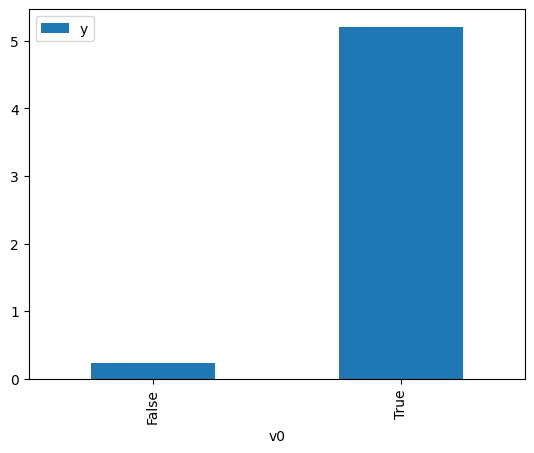

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

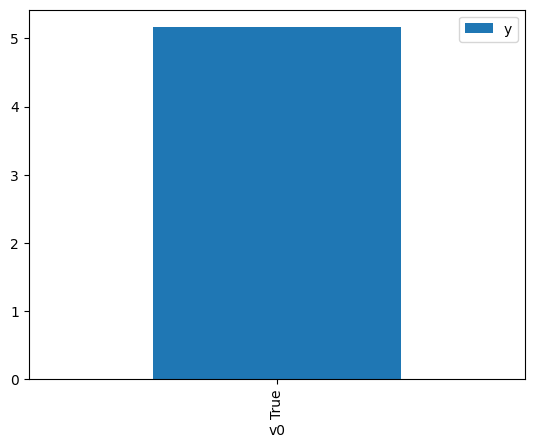

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,1.697916,False,1.468972,0.101582,9.844259
1,-0.341990,False,-0.059927,0.597120,1.674705
2,2.273554,False,2.619014,0.051862,19.281884
3,0.119804,False,-0.831116,0.452877,2.208104
4,1.643518,False,0.413432,0.108018,9.257723
...,...,...,...,...,...
995,1.594190,False,-0.076703,0.114161,8.759540
996,0.870639,False,1.636472,0.243019,4.114897
997,2.205635,False,-0.326551,0.056241,17.780780
998,0.296407,False,1.065887,0.398474,2.509576


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,1.609672,True,5.451182,0.887799,1.126381
1,0.540261,True,5.506882,0.672484,1.487025
2,-0.135107,True,5.727139,0.466922,2.141687
3,0.696171,True,4.460033,0.714249,1.400071
4,0.456202,True,4.756176,0.648717,1.541505
...,...,...,...,...,...
995,0.642677,True,4.559922,0.700280,1.427999
996,2.461847,True,3.886493,0.958649,1.043134
997,1.471927,True,6.394391,0.869290,1.150364
998,1.474978,True,4.236286,0.869727,1.149787


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.957
Model:                            OLS   Adj. R-squared (uncentered):              0.957
Method:                 Least Squares   F-statistic:                          1.120e+04
Date:                Fri, 19 Aug 2022   Prob (F-statistic):                        0.00
Time:                        21:53:13   Log-Likelihood:                         -1364.7
No. Observations:                1000   AIC:                                      2733.
Df Residuals:                     998   BIC:                                      2743.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2188      0.033      6.603      0.000       0.154       0.284
x2             4.9770      0.054     91.449      0.000       4.870       5.084
==============================================================================
Omnibus:                        4.370   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.112   Jarque-Bera (JB):                3.519
Skew:                           0.025   Prob(JB):                        0.172
Kurtosis:                       2.714   Cond. No.                         3.17
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""